In [1]:
import os
import numpy

from matplotlib import pyplot
%matplotlib notebook

from pypeit.spectrographs.keck_deimos import KeckDEIMOSSpectrograph
from pypeit.spectrographs.slitmask import SlitRegister
from pypeit import traceslits

In [2]:
mstrace_root = os.path.join(os.getenv('PYPEIT_DEV'),
                            'REDUX_OUT/Keck_DEIMOS/830G_M/MF_keck_deimos/MasterTrace_A_01_aa')
Tslits = traceslits.TraceSlits.from_master_files(mstrace_root)

[INFO]    :: traceslits.py 191 from_master_files() - Loading BPM from /Users/westfall/Work/packages/PypeIt-development-suite/REDUX_OUT/Keck_DEIMOS/830G_M/MF_keck_deimos/MasterTrace_A_01_aa.fits.gz


Text(0,0.5,'Slit Y (mm, spectral)')

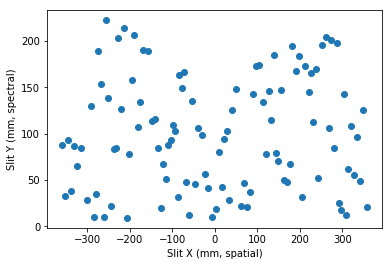

In [3]:
spec = KeckDEIMOSSpectrograph()
f = os.path.join(os.environ['PYPEIT_DEV'],
                 'RAW_DATA/Keck_DEIMOS/830G_M/DE.20100913.22358.fits.gz')
spec.get_slitmask(f)
spec.get_detector_map()
pyplot.scatter(spec.slitmask.center[:,0],spec.slitmask.center[:,1])
pyplot.xlabel('Slit X (mm, spatial)')
pyplot.ylabel('Slit Y (mm, spectral)')

Guess [4246.85         11.60421941]
Fit [4226.57503781   11.6822907 ]
Matched slits [ 70  54  89  47  32  72  22   1  83  15   7  81   5   3  33  97  73  44
  35  96  17  39 105]


Text(0,0.5,'Best-Fit Mask X (pixel)')

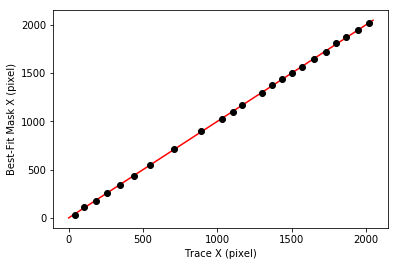

In [4]:
# Use the trace center
trace_slit_cen = (Tslits.lcen[3900,:] + Tslits.rcen[3900,:])/2

# Offset is edge of the first detector
offset = spec.detector_map.npix[0]/2-spec.detector_map.ccd_center[0,0]

# Scale is pixels/mm: (arcsec/mm)/ (Arcsec/pixel)
pix_per_mm = spec.telescope.platescale()/spec.detector[0]['platescale']

register = SlitRegister(trace_slit_cen, spec.slitmask.center[:,0],
                        guess_offset=offset, guess_scale=pix_per_mm,
                        offset_limits=[offset-100,offset+100],
                        scale_limits=[pix_per_mm/1.1, pix_per_mm*1.1],
                        fit=True)

print('Guess', register.guess_par)
print('Fit', register.par)
print('Matched slits', register.match_index)

pyplot.scatter(trace_slit_cen, register.mask_to_trace_coo()[register.match_index],
               color='k', zorder=1)
pyplot.plot([0,2048],[0,2048], color='r', zorder=0)
pyplot.xlabel('Trace X (pixel)')
pyplot.ylabel('Best-Fit Mask X (pixel)')

Found 3 missing slits: [103, 102, 71]


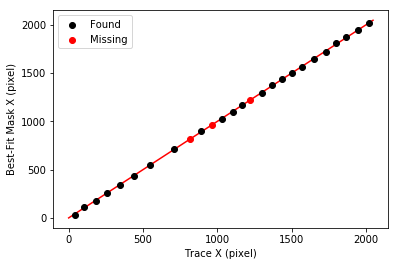

In [5]:
missing = register.missing_from_trace()
mask_pix = register.mask_to_trace_coo()
pyplot.plot([0,2048],[0,2048], color='r', zorder=0)
pyplot.scatter(trace_slit_cen, mask_pix[register.match_index], color='k', zorder=1,
               label='Found')
if len(missing) > 0:
    print('Found {0} missing slits: {1}'.format(len(missing), missing))
    pyplot.scatter(mask_pix[missing], mask_pix[missing], color='r', zorder=1,
                   label='Missing')
pyplot.xlabel('Trace X (pixel)')
pyplot.ylabel('Best-Fit Mask X (pixel)')
pyplot.legend()